In [1]:
import torch

Importing `torch` takes time

In [2]:
from transformers import SimpleDecoderTransformer
from transformers.constants import DataSplit
from transformers.train import train_transformer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Hyper Parameters

In [4]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90

batch_size = 16
context_length = 64

n_embd = 64
n_layer = 4
num_head = 4
dropout = 0.2

learning_rate = 3e-4
max_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 50
eval_iters = 10

# --------------------------------------------------------------------------------------------------- #

In [5]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cpu, cuda version: 11.8'

## Loading the Dataset

### Opening and Reading the File

In [6]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [7]:
vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [8]:
stoi = {ch: i for i, ch in enumerate(vocabulary)}
itos = {i: ch for i, ch in enumerate(vocabulary)}

def encode(x): return [stoi[ch] for ch in x]
def decode(x): return ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [9]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [10]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [11]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN.name else val_data

## Training and Testing the Model

In [12]:
model = SimpleDecoderTransformer(
    vocabulary_size=vocab_size,
    embedding_dim=n_embd,
    context_length=context_length,
    number_of_layers=n_layer,
    number_of_heads=num_head,
    dropout=dropout,
    device=device
).to(device)

TypeError: SimpleDecoderTransformer.__init__() got an unexpected keyword argument 'bidirectional_attention'

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    get_data=get_data,
    batch_size=batch_size,
    context_length=context_length,
    maximum_iterations=max_iters,
    eval_intervals=eval_intervals,
    eval_iterations=eval_iters,
    device=device
)

  4%|▍         | 4/100 [00:00<00:08, 11.87it/s]

Iteration[  1/100], Training Loss:  4.287473, Validation Loss:  4.294418


 52%|█████▏    | 52/100 [00:02<00:02, 16.81it/s]

Iteration[ 51/100], Training Loss:  3.302886, Validation Loss:  3.330880


100%|██████████| 100/100 [00:04<00:00, 23.38it/s]

Final Loss:
	Training:  3.302886
	Validation:  3.330880


In [15]:
generate_next_tokens = 100
prompt = 'What is life?'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
# idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'User: {prompt}\nModel: {generation}')

User: What is life?
Model: What is life?STTid ayarIretIt lececB bMFetH,etolu Ba tTcfe oh
p uthh.lheouQe t hd RhsyiDtp x n.Ae tddM duine p s-


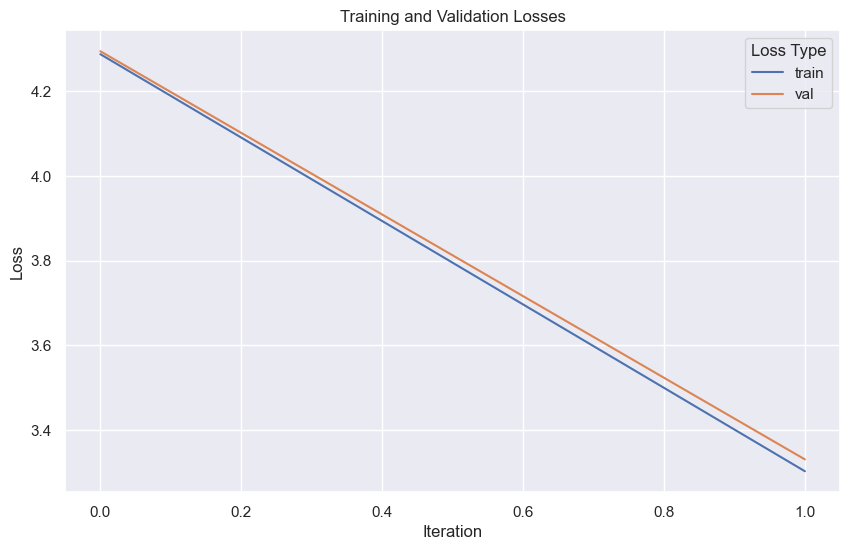

In [16]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN.name])),
    'train': all_losses[DataSplit.TRAIN.name],
    'val': all_losses[DataSplit.VALIDATION.name]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [17]:
torch.save(model, 'weights/tinyGPT.pb')